In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data/flavors_of_cacao.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('\n', '_')

In [4]:
rename = {'company\xa0_(maker-if_known)' : 'company',
            'specific_bean_origin_or_bar_name' : 'bean_origin'}
df.rename(columns=rename, inplace=True)
df.head()

,company,bean_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [5]:
df['cocoa_percent'] = df['cocoa_percent'].str.replace('%', '')
df['cocoa_percent'] = pd.to_numeric(df.cocoa_percent,errors='coerce')

In [6]:
cat = list(df.columns[df.dtypes == 'object'])
for c in cat:
    df[c] = df[c].str.lower().str.replace(' ', '_').str.replace('\n', '_')

In [7]:
df.isna().sum()

company              0
bean_origin          0
ref                  0
review_date          0
cocoa_percent        0
company_location     0
rating               0
bean_type            1
broad_bean_origin    1
dtype: int64

In [8]:
df = df.dropna()

In [9]:
from sklearn.metrics import mutual_info_score

In [10]:
def mutual_implement(df_f):
    return mutual_info_score(df_f, df.rating)

In [11]:
mut_inf = df[cat].apply(mutual_implement)
mut_inf

c:\python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\python38\lib\site-packages\sklearn\metrics\cl

company              0.860894
bean_origin          1.320412
company_location     0.158534
bean_type            0.088916
broad_bean_origin    0.203131
dtype: float64

In [12]:
num = list(df.columns[df.dtypes != 'object'])
df[num].corrwith(df.rating)

ref              0.101747
review_date      0.100332
cocoa_percent   -0.164758
rating           1.000000
dtype: float64

In [13]:
feat = ['ref', 'cocoa_percent',
 'company_location',
 'bean_type',
 'broad_bean_origin']

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.rating.values
y_val = df_val.rating.values
y_test = df_test.rating.values

df_train = df_train[feat]
df_test = df_test[feat]
df_val = df_val[feat]
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
# del df_train['rating']
# del df_val['rating']
# del df_test['rating']

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [18]:
df_train.ref = np.log1p(df_train.ref)
df_test.ref = np.log1p(df_test.ref)
df_val.ref = np.log1p(df_val.ref)

In [19]:
mlr = LinearRegression()
dv = DictVectorizer(sparse=True)
dict_train = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dict_train)
dict_val = df_val.to_dict(orient='records')
X_val = dv.transform(dict_val)
dict_test = df_test.to_dict(orient='records')
X_test = dv.transform(dict_test)

In [20]:
mlr.fit(X_train, y_train)

LinearRegression()

In [21]:
y_pred = mlr.predict(X_val)

In [22]:
import seaborn as sns

In [23]:
df_train.broad_bean_origin.value_counts(normalize=True)

venezuela                  0.121860
ecuador                    0.104186
dominican_republic         0.085581
peru                       0.081860
madagascar                 0.079070
                             ...   
ven,_trinidad,_ecuador     0.000930
venezuela,_trinidad        0.000930
ven.,_trinidad,_mad.       0.000930
central_and_s._america     0.000930
ven.,_indonesia,_ecuad.    0.000930
Name: broad_bean_origin, Length: 83, dtype: float64

In [26]:
np.sqrt(mean_squared_error(y_val, y_pred))

0.44867415202460764

<AxesSubplot:ylabel='Count'>

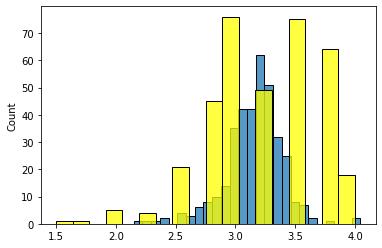

In [25]:
sns.histplot(y_pred)
sns.histplot(y_val, color='yellow')

In [44]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [28]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [29]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [30]:
y_pred = rfr.predict(X_val)

In [31]:
np.sqrt(mean_squared_error(y_val, y_pred))

0.44952625028574905

In [43]:
scores = []
for d in [3, 5, 10, 15]:
    rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=d)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((d,rmse))

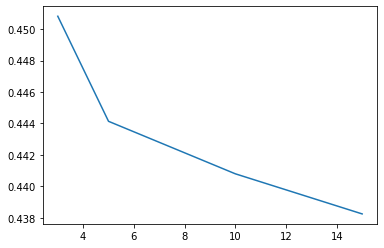

In [45]:
df_res = pd.DataFrame(scores, columns=['depth', 'rmse'])
plt.plot(df_res.depth, df_res.rmse)

In [46]:
scores = []
for d in [3, 5, 10, 15, 50, 100]:
    rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=10, max_leaf_nodes=d)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((d,rmse))

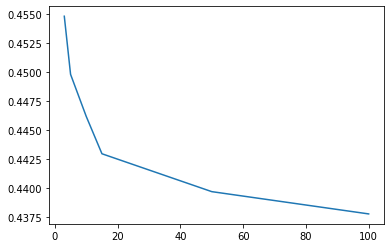

In [47]:
df_res = pd.DataFrame(scores, columns=['leafs', 'rmse'])
plt.plot(df_res.leafs, df_res.rmse)

In [51]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=12, max_leaf_nodes=100)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.4389943821934156

<AxesSubplot:ylabel='Count'>

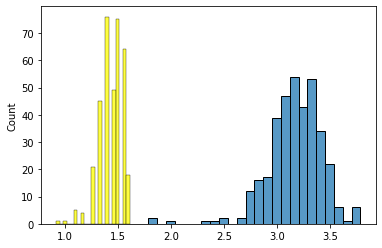

In [37]:
sns.histplot((y_pred))
sns.histplot(np.log1p(y_val), color='yellow')

In [33]:
import xgboost as xgb

In [42]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [52]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_leaf_child': 30,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric' : 'mse',
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=5)

XGBoostError: [10:11:44] C:\Users\Administrator\workspace\xgboost-win64_release_1.6.0\src\metric\metric.cc:49: Unknown metric function mse